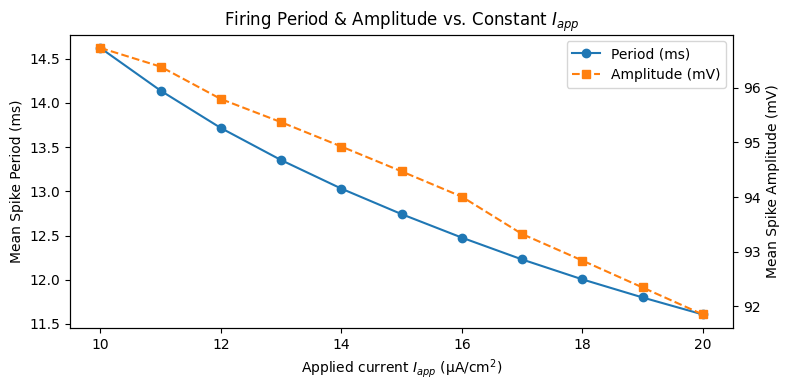

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ---- 1) Model parameters ----
C       = 1.0    # μF/cm²
gbar_K  = 36.0   # mS/cm²
gbar_Na = 120.0  # mS/cm²
g_leak  = 0.3    # mS/cm²
E_K     = -72.0  # mV
E_Na    = 55.0   # mV
E_leak  = -49.0  # mV

# ---- 2) Rate constants α and β ----
def alpha_n(V):
    return 0.01*(V + 50.0) / (1.0 - np.exp(-(V + 50.0)/10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 60.0)/80.0)

def alpha_m(V):
    return 0.1*(V + 35.0) / (1.0 - np.exp(-(V + 35.0)/10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 60.0)/18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 60.0)/20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 30.0)/10.0))

# ---- 3) Steady-states and time-constants from α+β ----
def n_inf(V):
    an = alpha_n(V); bn = beta_n(V)
    return an / (an + bn)

def tau_n(V):
    an = alpha_n(V); bn = beta_n(V)
    return 1.0 / (an + bn)

def m_inf(V):
    am = alpha_m(V); bm = beta_m(V)
    return am / (am + bm)

def tau_m(V):
    am = alpha_m(V); bm = beta_m(V)
    return 1.0 / (am + bm)

def h_inf(V):
    ah = alpha_h(V); bh = beta_h(V)
    return ah / (ah + bh)

def tau_h(V):
    ah = alpha_h(V); bh = beta_h(V)
    return 1.0 / (ah + bh)

# # ---- 4) Stimulus current I_app(t) ----
# def I_app(t):
#     if   t < 20.0:        return 0.0
#     elif t < 21.0:        return 2.0
#     elif t < 60.0:        return 0.0
#     elif t < 61.0:        return 10.0
#     else:                 return 0.0

# # I_app=np.linspace(10,20,11)
# I_app=[10,15,20]

# ---- 5) The HH ODE system ----
# State vector y = [ V, n, m, h ]
def hh_rhs(y, t,I):
    V, n, m, h = y


    # gating derivatives in the m∞–τ form
    dn = (n_inf(V) - n) / tau_n(V)
    dm = (m_inf(V) - m) / tau_m(V)
    dh = (h_inf(V) - h) / tau_h(V)

    # conductances
    gK  = gbar_K  * n**4
    gNa = gbar_Na * m**3 * h
    Ileak = g_leak * (V - E_leak)

    # currents (note sign: I_K = gK*(V - E_K), etc.)
    IK  = gK  * (V - E_K)
    INa = gNa * (V - E_Na)

    # membrane equation
    dV = ( I - IK - INa - Ileak ) / C

    return [dV, dn, dm, dh]




# ---- 5) Simulate for I_app from 10 to 20 µA/cm² ----
currents = np.arange(10, 21, 1)
periods = []
amplitudes = []

t = np.linspace(0, 100, 5001)
y0 = [-59.8977, n_inf(-59.8977), m_inf(-59.8977), h_inf(-59.8977)]
V_rest = y0[0]

for I in currents:
    sol = odeint(hh_rhs, y0, t, args=(I,))
    V = sol[:,0]
    # detect spike times: upward threshold crossing at 0 mV
    thr_mask = (V[:-1] < 0) & (V[1:] >= 0)
    spike_times = t[:-1][thr_mask]
    if len(spike_times) > 1:
        periods.append(np.mean(np.diff(spike_times)))
    else:
        periods.append(np.nan)
    # detect peaks (local maxima)
    idx = np.where((V[1:-1] > V[:-2]) & (V[1:-1] > V[2:]))[0] + 1
    if len(idx) > 0:
        peak_vals = V[idx]
        amplitudes.append(np.mean(peak_vals) - V_rest)
    else:
        amplitudes.append(np.nan)

# ---- 6) Plot period and amplitude vs current ----
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.plot(currents, periods, 'o-', label='Period (ms)')
ax2.plot(currents, amplitudes, 's--', color='C1', label='Amplitude (mV)')

ax1.set_xlabel('Applied current $I_{app}$ (µA/cm$^2$)')
ax1.set_ylabel('Mean Spike Period (ms)')
ax2.set_ylabel('Mean Spike Amplitude (mV)')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.title('Firing Period & Amplitude vs. Constant $I_{app}$')
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
# Display numerical results in a table
df = pd.DataFrame({'I_app (µA/cm²)': currents,
                   'Mean Period (ms)': periods,
                   'Mean Amplitude (mV)': amplitudes})
df

,I_app (µA/cm²),Mean Period (ms),Mean Amplitude (mV)
0,10,14.623333,96.730750
1,11,14.140000,96.387308
2,12,13.717143,95.795142
3,13,13.354286,95.371464
4,14,13.031429,94.925652
5,15,12.742857,94.470865
6,16,12.477143,94.007501
7,17,12.230000,93.324243
8,18,12.005000,92.839324
9,19,11.800000,92.346014
